In [ ]:
##  Data Set:  Multi PIE  (Multi Pose, Illumination, Expressions)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import glob
import pandas as pd
import random
import numpy as np
import cv2
import base64
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm
from pprint import pprint
from PIL import Image
from time import localtime, strftime
from sklearn.model_selection import train_test_split
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cuda


In [2]:
import random
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
import copy
import os
#import random
import shutil
#import time
from zipfile import ZipFile
import  pathlib
from os import walk
import time
from datetime import datetime


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# create folder in runtime env
pathlib.Path('./MultiPIE/train').mkdir(parents=True, exist_ok=True)

pathlib.Path('./MultiPIE/test').mkdir(parents=True, exist_ok=True)

In [8]:
# Unzip the color.zip file from google drive to the current runtime for faster access.
zipped_data_file_name = '/content/drive/MyDrive/major_project/data/train_jan22.zip'
with ZipFile(zipped_data_file_name, 'r') as zip_ref:
    zip_ref.extractall(path= '/content/MultiPIE/train')

In [10]:
# Unzip the color.zip file from google drive to the current runtime for faster access.
zipped_data_file_name = '/content/drive/MyDrive/major_project/data/test_jan22.zip'
with ZipFile(zipped_data_file_name, 'r') as zip_ref:
    zip_ref.extractall(path= '/content/MultiPIE/test')

In [11]:
TRAIN_DATASET_PATH ="/content/MultiPIE/train"
TEST_DATASET_PATH ="/content/MultiPIE/test"


In [12]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader, random_split


In [13]:
IMAGE_SIZE = 160
BATCH_SIZE = 12
#BATCH_SIZE=1 to display all angles pertaining to a single individual while testing use this

In [14]:
#Refer https://idiap.ch/software/beat/docs/bob/docs/stable/bob/bob.bio.face/doc/leaderboard/multipie.html

# 219_01_02_051_07.png

# 219 is person
# 01 - session
# 02 - expression (1 : neutral, smile   2 : neutral, surprise, squint  3 : neutral, smile, disgust 4 : neutral, neutral, scream.)
# 051 - camera
# 07 - illumination

# Camera:
# 051 - front looking -> base image  use attribute 4 (middle)

# When viewed from back in pic above:
# Left side 3 cameras:
# 080 use attribute 0
# 130 use attribute 1
# 140 use attribute 2
# Right side 3 cameras:
# 050 use attribute 4
# 041 use attribute 5
# 190 use attribute 6

#------------- Flash light illumination:
# 4 flash at camera 080
# 5 flash at camera 130
# 6 flash at camera 140
# 7 flash at camera 051
# 8 flash at camera 050
# 9 flash at camera 041
# 10 flash at camera 190

#15,16,17 flashes are above head and not realted to any camera

#face_0 = listing[0]

camera_positions = ['080', '130','140','051','050','041','190',]
# #flash_positions =  ['04','05','06','07','08','09','10',]
# flash_positions =  ['04','05','06','08','09','10',]  # dont use the flash at camera 51


In [15]:
values = [1,2,3,4,5,6,7]
n_values = np.max(values) + 1
# one_hot_arr = np.eye(n_values)[values]
one_hot_arr = torch.eye(n_values,dtype=torch.float32)
print(one_hot_arr)



tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]])


In [17]:
train_images_count = 0

In [18]:
# #### The below is commented on Feb 7, 2005 and the modified dataset is below. This commented one creates data which moves straight looking face
# #### to other angles.
# Step 1. Train for:

#    3->0
#    3->1
#    3->2
#    3->4
#    3->5
#    3->6


# """
#  We do not need to divide by 255, the MultiPIE  data set is already 0.0 - 1.0

# """

# import glob


# class ClampTransform(object): #nn.Module):
#     def __init__(self, min_value, max_value):
#         super().__init__()
#         self.min = min_value
#         self.max = max_value

#     #def forward(self, tensor1):
#     def __call__(self, tensor1):
#         return torch.clamp(tensor1, min=self.min, max=self.max)

# clamp_transform = ClampTransform(0.005, 0.995)

# class MultiPIE_DS1_TiltToAngles(Dataset):
#     def __init__(self, image_dir):
#         super().__init__()
#         #self.dsname = image_dir
#         self.transform = transforms.Compose([
#                  # torchvision.transforms.Normalize()  does it reduce the clarity?
#                  # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

#                  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#                  transforms.ToTensor(),
#                  ## #clamp_transform(), do not call this instance, since it calls the __call__ directly and tensor param is missing. Instead mention the class as below
#                  ClampTransform(0.005, 0.995),
#         ])

#         self.dir = image_dir
#         #self.imgs = os.listdir(image_dir)
#         self.imgs = glob.glob( self.dir +  '/*_051_*.png')
#         self.length = len(self.imgs)
#         #print(f'{self.length=}')

#     def __len__(self):
#         return self.length

#     def __getitem__(self, idx):
#         global train_images_count

#         # # if torch.is_tensor(idx):
#         # #     idx = idx.tolist()
#         # print(f'{idx=}')

#         ##print(f' trying to get record number: {i} {self.dsname}')

#         face_0_filename = self.imgs[idx]
#         #print(f' face_0_filename = {face_0_filename}')
#         face_0_parts = face_0_filename.split('_051_')

#         target_images = []
#         target_onehot = []
#         target_file_names=[]


#         for j in range(7):  # allow 0,1,2 and 4,5,6  (the last entry of the tensor is unused as of now....
#           #print(f'- {j} ->',end='')


#           if j == 3:  # 3-> straight looking camera used as source
#             #print('')
#             continue


#           tgt_filename = face_0_parts[0]+'_'+camera_positions[j]+'_'+face_0_parts[1]
#           if os.path.isfile(tgt_filename):
#               target_images.append( self.transform(Image.open( tgt_filename )) )
#               # # #target_file_names.append(tgt_filename)
#               # print(f'{face_0_filename=}  {tgt_filename=}')
#               # print(f' -- found,  so one_hot_arr index will be :  {j} ' )
#               target_onehot.append( one_hot_arr[j] )


#           # #-----------------------------
#           # # Feb 5, 2025, the below can be used for all the 6 flash positions, we have already trained 2 epochs and then commented to continue
#           # # with single light source
#           # for flash_pos in range(len(flash_positions)):

#           #       #tgt_filename = face_0_parts[0]+'_'+camera_positions[j]+'_'+face_0_parts[1]
#           #       tgt_filename = face_0_parts[0]+'_'+camera_positions[j]+'_'+ flash_positions[flash_pos] + '.png'

#           #       #print(f' tgt_filename = {tgt_filename}' , end='')

#           #       if os.path.isfile(tgt_filename):
#           #           target_images.append( self.transform(Image.open( tgt_filename )) )
#           #           # # #target_file_names.append(tgt_filename)
#           #           # print(f'{face_0_filename=}  {tgt_filename=}')
#           #           # print(f' -- found,  so one_hot_arr index will be :  {j} ' )
#           #           target_onehot.append( one_hot_arr[j] )
#           # #-----------------------------



#         src_imgs = [ self.transform(Image.open( self.imgs[idx])) ] * len(target_images)
#         #output_img = self.transform(Image.open(self.dir + self.imgs[i]))
#         #print(output_img)
#         #return output_img
#         train_images_count += len(src_imgs)
#         return  src_imgs,  target_images  , target_onehot  #,target_file_names



In [19]:
### this dataset creates data which moves other angle images to straightlooking....
###  so from the previous(above) dataset, src_imgs and tgt_imgs will be swapped.
###  Target Vectors has to be reversed, so that we can use previous checkpoints and apply transfer learning???

# Step 2. Train for:

#    0->3
#    1->3
#    2->3
#    4->3
#    5->3
#    6->3


"""
 We do not need to divide by 255, the MultiPIE  data set is already 0.0 - 1.0
"""
import glob

class ClampTransform(object): #nn.Module):
    def __init__(self, min_value, max_value):
        super().__init__()
        self.min = min_value
        self.max = max_value

    #def forward(self, tensor1):
    def __call__(self, tensor1):
        return torch.clamp(tensor1, min=self.min, max=self.max)

clamp_transform = ClampTransform(0.005, 0.995)

class MultiPIE_DS1(Dataset):
    def __init__(self, image_dir):
        super().__init__()
        #self.dsname = image_dir
        self.transform = transforms.Compose([
                 # torchvision.transforms.Normalize()  does it reduce the clarity?
                 # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

                 transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                 transforms.ToTensor(),
                 ## #clamp_transform(), do not call this instance, since it calls the __call__ directly and tensor param is missing. Instead mention the class as below
                 ClampTransform(0.005, 0.995),
        ])

        self.dir = image_dir
        self.imgs = glob.glob( self.dir +  '/*_051_*.png')
        self.length = len(self.imgs)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        global train_images_count


        face_0_filename = self.imgs[idx]

        face_0_parts = face_0_filename.split('_051_')

        target_images = []
        target_onehot = []
        target_file_names=[]


        for j in range(7):  # allow 0,1,2 and 4,5,6  (the last entry of the tensor is unused as of now....
          #print(f'- {j} ->',end='')


          if j == 3:  # 3-> straight looking camera used as source
            #print('')
            continue


          tgt_filename = face_0_parts[0]+'_'+camera_positions[j]+'_'+face_0_parts[1]
          if os.path.isfile(tgt_filename):
              target_images.append( self.transform(Image.open( tgt_filename )) )
              # # #target_file_names.append(tgt_filename)
              # print(f'{face_0_filename=}  {tgt_filename=}')
              # print(f' -- found,  so one_hot_arr index will be :  {j} ' )

              #target_onehot.append( one_hot_arr[j] ) # Feb 7,2025
              #target_onehot.append( one_hot_arr[6-j] ) # Feb 7,2025
              target_onehot.append( one_hot_arr[3] ) # Feb 7,2025


          # #-----------------------------
          # # Feb 5, 2025, the below can be used for all the 6 flash positions, we have already trained 2 epochs and then commented to continue
          # # with single light source
          # for flash_pos in range(len(flash_positions)):

          #       #tgt_filename = face_0_parts[0]+'_'+camera_positions[j]+'_'+face_0_parts[1]
          #       tgt_filename = face_0_parts[0]+'_'+camera_positions[j]+'_'+ flash_positions[flash_pos] + '.png'

          #       #print(f' tgt_filename = {tgt_filename}' , end='')

          #       if os.path.isfile(tgt_filename):
          #           target_images.append( self.transform(Image.open( tgt_filename )) )
          #           # # #target_file_names.append(tgt_filename)
          #           # print(f'{face_0_filename=}  {tgt_filename=}')
          #           # print(f' -- found,  so one_hot_arr index will be :  {j} ' )
          #           target_onehot.append( one_hot_arr[j] )
          # #-----------------------------



        src_imgs = [ self.transform(Image.open( self.imgs[idx])) ] * len(target_images)
        #output_img = self.transform(Image.open(self.dir + self.imgs[i]))
        #print(output_img)
        #return output_img
        train_images_count += len(src_imgs)

        #return  src_imgs,  target_images  , target_onehot  #,target_file_names  # Feb 7 , 2025
        return   target_images, src_imgs  , target_onehot  # Feb 7 , 2025





In [20]:
# # ##   train on the below, after some epochs using the above 2 datasets
# # 0->1
# # 0->2
# # 0->3  This will help in tuning the representation of 3 along with others????
# # 0->4
# # 0->5
# # 0->6


# """
#  We do not need to divide by 255, the MultiPIE  data set is already 0.0 - 1.0

# """

# import glob


# class ClampTransform(object): #nn.Module):
#     def __init__(self, min_value, max_value):
#         super().__init__()
#         self.min = min_value
#         self.max = max_value

#     #def forward(self, tensor1):
#     def __call__(self, tensor1):
#         return torch.clamp(tensor1, min=self.min, max=self.max)

# clamp_transform = ClampTransform(0.005, 0.995)

# class MultiPIE_DS1_valli(Dataset):
#     def __init__(self, image_dir):
#         super().__init__()
#         #self.dsname = image_dir
#         self.transform = transforms.Compose([
#                  # torchvision.transforms.Normalize()  does it reduce the clarity?
#                  # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

#                  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#                  transforms.ToTensor(),
#                  ## #clamp_transform(), do not call this instance, since it calls the __call__ directly and tensor param is missing. Instead mention the class as below
#                  ClampTransform(0.005, 0.995),
#         ])

#         self.dir = image_dir
#         #self.imgs = os.listdir(image_dir)
#         self.imgs = glob.glob( self.dir +  '/*_080_*.png')    #  '/*_051_*.png')
#         self.length = len(self.imgs)

#         # print(f'{self.length=}')
#         # print(f'{self.imgs[1:3]}')



#     def __len__(self):
#         return self.length

#     def __getitem__(self, idx):
#         global train_images_count

#         # # if torch.is_tensor(idx):
#         # #     idx = idx.tolist()
#         # print(f'{idx=}')

#         ##print(f' trying to get record number: {i} {self.dsname}')

#         face_0_filename = self.imgs[idx]
#         #print(f' face_0_filename = {face_0_filename}')
#         face_0_parts = face_0_filename.split('_080_')  # ('_051_')

#         target_images = []
#         target_onehot = []
#         target_file_names=[]


#         for j in range(7):  # allow 0,1,2 and 4,5,6  (the last entry of the tensor is unused as of now....
#           #print(f'- {j} ->',end='')


#           if j == 0:  #   Feb 7, 0'th index used as source now
#             continue


#           tgt_filename = face_0_parts[0]+'_'+camera_positions[j]+'_'+face_0_parts[1]
#           if os.path.isfile(tgt_filename):
#               target_images.append( self.transform(Image.open( tgt_filename )) )
#               # # #target_file_names.append(tgt_filename)
#               # print(f'{face_0_filename=}  {tgt_filename=}')
#               # print(f' -- found,  so one_hot_arr index will be :  {j} ' )

#               #target_onehot.append( one_hot_arr[j] ) # Feb 7,2025
#               #target_onehot.append( one_hot_arr[6-j] ) # Feb 7,2025
#               target_onehot.append( one_hot_arr[j] ) # Feb 7,2025

#           # #-----------------------------
#           # # Feb 5, 2025, the below can be used for all the 6 flash positions, we have already trained 2 epochs and then commented to continue
#           # # with single light source
#           # for flash_pos in range(len(flash_positions)):

#           #       #tgt_filename = face_0_parts[0]+'_'+camera_positions[j]+'_'+face_0_parts[1]
#           #       tgt_filename = face_0_parts[0]+'_'+camera_positions[j]+'_'+ flash_positions[flash_pos] + '.png'

#           #       #print(f' tgt_filename = {tgt_filename}' , end='')

#           #       if os.path.isfile(tgt_filename):
#           #           target_images.append( self.transform(Image.open( tgt_filename )) )
#           #           # # #target_file_names.append(tgt_filename)
#           #           # print(f'{face_0_filename=}  {tgt_filename=}')
#           #           # print(f' -- found,  so one_hot_arr index will be :  {j} ' )
#           #           target_onehot.append( one_hot_arr[j] )
#           # #-----------------------------



#         src_imgs = [ self.transform(Image.open( self.imgs[idx])) ] * len(target_images)
#         #output_img = self.transform(Image.open(self.dir + self.imgs[i]))
#         #print(output_img)
#         #return output_img
#         train_images_count += len(src_imgs)

#         return  src_imgs,  target_images  , target_onehot  #,target_file_names  # Feb 7 , 2025



In [21]:
def get_dataloaders():

    train_ds = MultiPIE_DS1('/content/MultiPIE/train/')
    test_ds = MultiPIE_DS1('/content/MultiPIE/test/')

    # train_ds, test_ds = random_split(celeb_a, [0.8, 0.2])
    # print('Train data size: {}'.format(len(train_ds)))
    # print('Test data size: {}'.format(len(test_ds)))

    train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    test_loader =  DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    print(f' train_ds.length={train_ds.length}  - test_ds.length={test_ds.length}  ')

    return train_loader, test_loader

In [22]:
# Check dataset
_ , check_ds = get_dataloaders()
#check_samples = next(iter(check_ds))

src_imgs,  target_images  , targets_onehot  = next(iter(check_ds))
print(f' --> {len(src_imgs)}')
src_imgs = torch.stack(src_imgs)
src_imgs = src_imgs.reshape(-1,3,160,160)
target_images = torch.stack(target_images)
target_images = target_images.reshape(-1,3,160,160)
targets_onehot = torch.stack(targets_onehot)
targets_onehot = targets_onehot.reshape(-1,8)
targets_onehot = targets_onehot.float()

# print(src_imgs.shape)
# print(target_images.shape)
# print(targets_onehot.shape)

fig = plt.figure(figsize=(84, 80))

grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(16, 2),  # creates 2x2 grid of Axes
                 axes_pad=0.1,  # pad between Axes in inch.
                 )

img_array = []

for i in range(16):
  #  img_array.append(src_imgs[i].permute(1, 2, 0).clamp(0.0, 1.0) )
  #  img_array.append(target_images[i].permute(1, 2, 0).clamp(0.0, 1.0) )

   img_array.append(src_imgs[i].permute(1, 2, 0) )
   img_array.append(target_images[i].permute(1, 2, 0))



for ax, im in zip(grid, img_array ):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)


plt.show()

 train_ds.length=7164  - test_ds.length=1800  
 --> 6


In [23]:
train_dataloader, test_dataloader = get_dataloaders()

 train_ds.length=7164  - test_ds.length=1800  


In [24]:
DIM_X = 160
DIM_Y = 160

IMAGE_H = 160
IMAGE_W = 160
N_CHANNELS = 3

In [25]:
class EncoderDecoder(nn.Module):


    def __init__(self ) -> None:

        super().__init__()

        self.image_encoder = nn.Sequential(

                    # jan 26 -ref to the paper https://stephenjia.github.io/xjia_publications/xjia_bmvc16_facefinal.pdf
                    # They took inspiration from oxfordNet and mention that 2 consecutive conv layers  increase receptive field?

                    nn.Conv2d( 3 , 64 , 9 , 1 , 4),  # https://www.maplefan.com/conv-pool/
                    ## #nn.BatchNorm2d(64),
                    nn.ReLU(),

                    nn.Conv2d( 64 , 64 , 9 , 1 , 4),
                    #nn.BatchNorm2d(64),
                    nn.ReLU(),

                    nn.Conv2d( 64 , 128 ,  9 , 2 , 4),    # 160 -> 80
                    #.BatchNorm2d(128),
                    nn.ReLU(),

                    nn.Conv2d( 128 , 128 , 9 , 1 , 4),
                    #nn.BatchNorm2d(128),
                    nn.ReLU(),


                    nn.Conv2d( 128 , 256 , 9 , 2 , 4),    # 80 -> 40
                    #nn.BatchNorm2d(256),
                    nn.ReLU(),

                    nn.Conv2d( 256 , 256 ,  9 , 1 , 4),
                    #nn.BatchNorm2d(256),
                    nn.ReLU(),


        )

        # We could also use an embedding vector
        # difference between Embedding and Linear: Linear expects vectors (e.g. one-hot representation of the words),
        # Embedding expects tokens (e.g. words index)
        # Ref https://discuss.pytorch.org/t/how-does-nn-embedding-work/88518/2

        # lets make 8 feature maps from attributes, so we need 40*40*8 neurons in the 2nd layer
        self.attribute_encoder = nn.Sequential(
                    nn.Linear(8, 512),
                    #nn.Dropout(p=0.01), this is an embedding creator, so drop???
                    nn.Linear(512, 40 * 40 * 32, bias=True),
        )


        self.fusion_net = nn.Sequential(  # input 40*40 * 288 (256+32)

                    # --------------
                    nn.Conv2d( 288 , 256 , 9 , 1 , 4),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),

                    nn.Conv2d( 256 , 256 , 9 , 1 , 4),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),

                    nn.Conv2d( 256 , 256 , 9 , 1 , 4),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),

           )

        self.image_decoder = nn.Sequential(

                    nn.ConvTranspose2d( 256 , 128 ,  kernel_size=4, stride = 2, padding=1, output_padding=0 , bias=True), # 40 -> 80
                    nn.BatchNorm2d(128),
                    nn.ReLU(),

                    nn.Conv2d( 128 , 128 , 9 , 1 , 4),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),


                    nn.ConvTranspose2d( 128 , 64 ,  kernel_size=4, stride = 2, padding=1, output_padding=0 , bias=True), # 80 -> 160
                    nn.BatchNorm2d(64),
                    nn.ReLU(),

                    nn.Conv2d( 64 , 64 , 9 , 1 , 4),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),

                    nn.Conv2d( 64 , 3 , 9 , 1 , 4),
                    nn.ReLU(),

                )




    def forward(self, src_imgs , target_images , targets_onehot ):

        encoded_images  = self.image_encoder(src_imgs)

        encoded_attribs = self.attribute_encoder(targets_onehot)
        encoded_attribs  =  encoded_attribs.view(-1,32, 40, 40 )

        stacked_info    = torch.cat((encoded_images , encoded_attribs),1)  # channel wise concat???

        encoded_info    = self.fusion_net(stacked_info )

        result_images  = self.image_decoder(encoded_info)

        return result_images

    def loss_function(self, result_images , target_images , alpha=1 ) :
        recons_loss =F.mse_loss(result_images, target_images)
        recons_loss = recons_loss * alpha
        return { 'recons_loss' : recons_loss }


In [26]:
should_load_EncoderDecoder = True

In [27]:
def weights_init(m):
    classname = m.__class__.__name__
    #print(f'{classname=}')

    if classname.find('Conv') != -1:
        #nn.init.normal_(m.weight.data, 0.01, 0.001)  #https://homepage.divms.uiowa.edu/~mbognar/applets/normal.html
        nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0.0)

    elif classname.find('Linear') != -1:
        #nn.init.normal_(m.weight.data, 0.01, 0.010)
        nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0.0)

    elif classname.find('Norm') != -1:
        print(f'{classname} - Norm ???? .....')
        nn.init.normal_(m.weight.data, 0.1, 0.001)
        nn.init.constant_(m.bias.data, 0.0)
    else:
        print(f'{classname} - could not initialize.....')


model1 = EncoderDecoder()

if should_load_EncoderDecoder:
      state1 = torch.load("/content/drive/MyDrive/major_project/models/V8feb8_model1_towards_straight_valloss_9.9746.pth", weights_only=True, map_location=DEVICE)
      model1.load_state_dict(state1)   #['state_dict'])
      pass
else:
      model1.apply(weights_init)


model1.to(DEVICE)





EncoderDecoder(
  (image_encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (11): ReLU()
  )
  (attribute_encoder): Sequential(
    (0): Linear(in_features=8, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=51200, bias=True)
  )
  (fusion_net): Sequential(
    (0): Conv2d(288, 256, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 

In [28]:
def fit_epoch_model1(model1, optimizer1, batch_size):

    running_loss = 0.0
    processed_data = 0

    model1.train()

    #for inputs in next(iter(train_dataloader)) : # get_batch(train_x,batch_size):
    for i, inputs in enumerate(train_dataloader):

        #-------------------
        src_imgs,  target_images  , targets_onehot  = inputs  # next(iter(check_ds))

        src_imgs = torch.stack(src_imgs)
        src_imgs = src_imgs.reshape(-1,3,160,160)

        target_images = torch.stack(target_images)
        target_images = target_images.reshape(-1,3,160,160)

        targets_onehot = torch.stack(targets_onehot)
        targets_onehot = targets_onehot.reshape(-1,8)
        targets_onehot = targets_onehot.float()

        src_imgs = src_imgs.to(DEVICE)
        target_images = target_images.to(DEVICE)
        targets_onehot = targets_onehot.to(DEVICE)


        with torch.set_grad_enabled(True):

                    optimizer1.zero_grad()

                    #print(f'src_imgs.device = {src_imgs.device}')

                    result_images  = model1(src_imgs,target_images,targets_onehot  )

                    loss_dict = model1.loss_function( result_images , target_images ,alpha=1000 )
                    loss = loss_dict['recons_loss']

                    print(f" Reconstruction_Loss :  {loss.item()}    ")

                    loss.backward()
                    optimizer1.step()

        running_loss += loss.item() *  src_imgs.size(0)  # inputs.shape[0]
        processed_data +=  src_imgs.size(0)   #inputs.shape[0]

    train_loss = running_loss / processed_data
    return train_loss

def eval_epoch_vae_model1(model1, batch_size):

    running_loss = 0.0
    processed_data = 0
    model1.eval()

    for i, inputs in enumerate(test_dataloader):

          src_imgs,  target_images  , targets_onehot  = inputs  # next(iter(check_ds))

          src_imgs = torch.stack(src_imgs)
          src_imgs = src_imgs.reshape(-1,3,160,160)
          target_images = torch.stack(target_images)
          target_images = target_images.reshape(-1,3,160,160)
          targets_onehot = torch.stack(targets_onehot)
          targets_onehot = targets_onehot.reshape(-1,8)
          targets_onehot = targets_onehot.float()

          src_imgs = src_imgs.to(DEVICE)
          target_images = target_images.to(DEVICE)
          targets_onehot = targets_onehot.to(DEVICE)


          with torch.set_grad_enabled(False):

                    result_images  = model1(src_imgs,target_images,targets_onehot  )

                    loss_dict = model1.loss_function( result_images , target_images ,alpha=1000  )
                    loss = loss_dict['recons_loss']

                    print(f" test_Loss :  {loss.item()}    ")

          running_loss += loss.item() *  src_imgs.size(0)  # inputs.shape[0]
          processed_data +=  src_imgs.size(0)   #inputs.shape[0]


    val_loss = running_loss / processed_data
    return val_loss


def train_model1(  model1, epochs , batch_size , lr ):

    optimizer1 = torch.optim.Adam(model1.parameters(), lr=lr)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"

    counter = 0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss = fit_epoch_model1(model1,optimizer1,batch_size)
            val_loss = eval_epoch_vae_model1(model1,batch_size)

            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))

            counter += 1
            if counter % 1 == 0:
                  torch.save(model1.state_dict(), '/content/drive/MyDrive/major_project/models/V8feb9_model1_towards_straight_' + str(int(val_loss)) + '_' + str(counter) + '.pth')

    return history


should_train_model1  = False
#--------
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)
#----------
if should_train_model1:

    history_model1 = train_model1( model1, epochs=3, batch_size=BATCH_SIZE, lr=0.000002)

    # Save the model
    str1 = strftime("%Y_%m_%d_%H_%M_%S", localtime())
    torch.save(model1.state_dict(), '/content/drive/MyDrive/major_project/models/V8feb9_model1_towards_straight_eod_' + str1 + '.pth')

    # plot metrics
    train_loss, val_loss = zip(*history_model1)
    plt.figure(figsize=(15,10))
    plt.plot(train_loss, label='Train loss')
    plt.plot(val_loss, label='Val loss')
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.plot()


Current Time = 06:53:29


In [29]:
def test_vae(model1, X_test ):

    model1.eval()

    src_imgs,  target_images  , targets_onehot  = X_test  # next(iter(check_ds))

    src_imgs = torch.stack(src_imgs)
    src_imgs = src_imgs.reshape(-1,3,160,160)
    target_images = torch.stack(target_images)
    target_images = target_images.reshape(-1,3,160,160)
    targets_onehot = torch.stack(targets_onehot)
    targets_onehot = targets_onehot.reshape(-1,8)
    targets_onehot = targets_onehot.float()

    src_imgs = src_imgs.to(DEVICE)
    target_images = target_images.to(DEVICE)
    targets_onehot = targets_onehot.to(DEVICE)

    with torch.set_grad_enabled(False):
                 result_images  = model1(src_imgs,target_images,targets_onehot  )

    refined_images = result_images

    # Convert the tensors back to numpy for visualization
    # recon_images    = recon_batch.reshape(-1, IMAGE_H, IMAGE_W , 3).clone().detach().cpu().numpy()  # Reshape for images
    # original_images =   test_data.reshape(-1, IMAGE_H, IMAGE_W , 3).clone().detach().cpu().numpy()  # Original images

    #print(recon_batch.shape)
    recon_images = refined_images.permute(0, 2, 3, 1).contiguous() # 0 1 2 3
    original_images = src_imgs.permute(0, 2, 3, 1).contiguous() # 0 1 2 3


    recon_images    = recon_images.clone().detach().cpu().numpy()  # Reshape for images
    original_images =   original_images.clone().detach().cpu().numpy()  # Original images

    #print(recon_images.min())
    return original_images, recon_images

In [30]:
def plot_reconstructions(original_images, recon_images, num_samples=10):

    # Determine the number of samples to plot (minimum of available images and requested samples)
    num_samples = min(num_samples, original_images.shape[0], recon_images.shape[0])

    fig=plt.figure(figsize=(10, 5))

    for i in range(num_samples):

        # Plot original images
        plt.subplot(2, num_samples, i + 1)
        #img = Image.fromarray((test_data_np * 255).astype(np.uint8))

        plt.imshow( (original_images[i] * 255).astype(np.uint8) )
        plt.axis('off')
        plt.title("Original")

        # Plot reconstructed images
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow( (recon_images[i] * 255).astype(np.uint8)  )
        plt.axis('off')
        plt.title("Reconstructed")

    plt.tight_layout()

    fig.suptitle('using Sigmoid() ', fontsize=16)

    plt.show()


 train_ds.length=7164  - test_ds.length=1800  


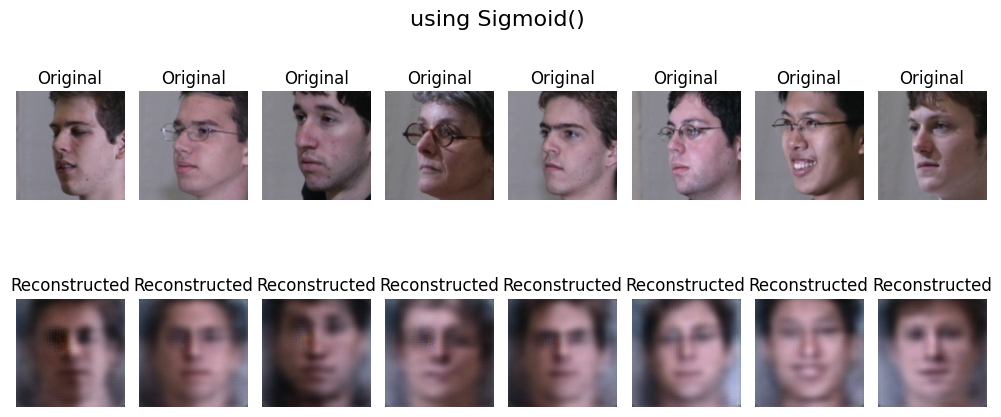

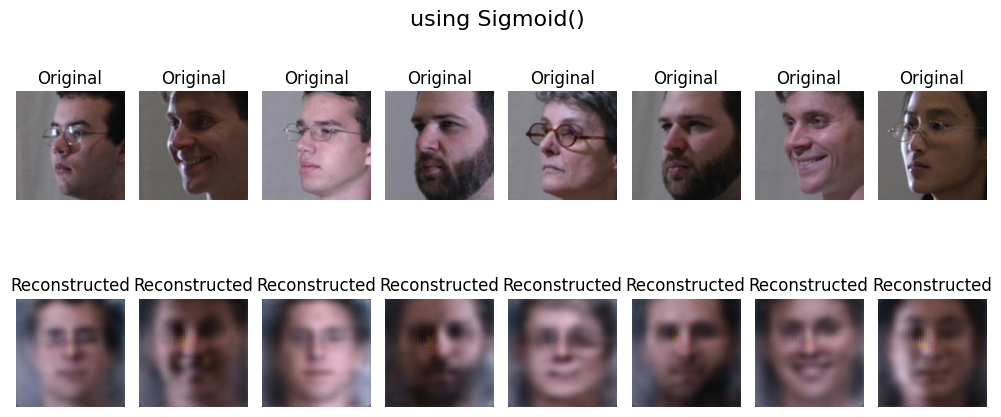

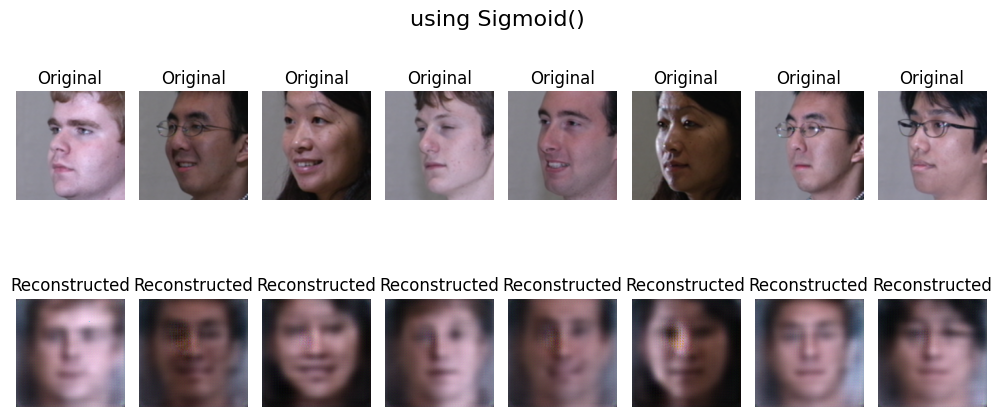

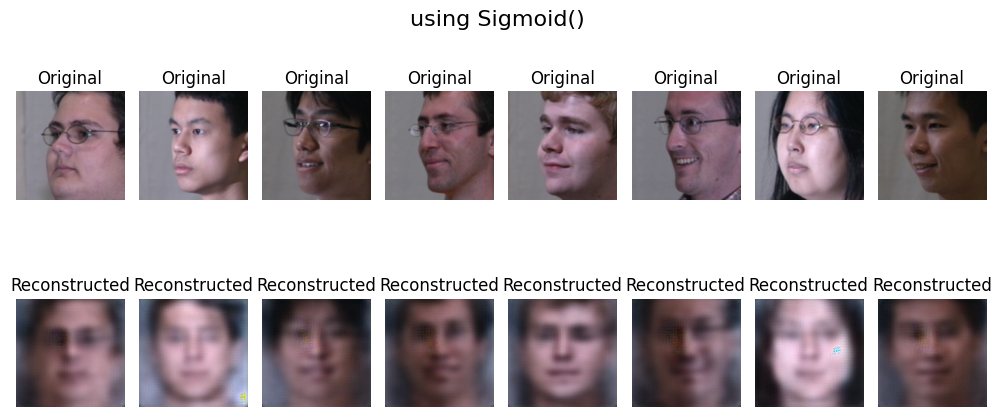

In [31]:
_, test_dataloader = get_dataloaders()
for i, inputs in enumerate(test_dataloader):
    if i in {1,2,3,4} :

          original_images, recon_images = test_vae(model1, inputs )
          plot_reconstructions(original_images , recon_images , num_samples=8)

          if i > 4:
               break